This notebook provides examples of how to call the hyperconvo functions from Convokit and perform analyses similar to the ones presented in the corresponding paper (http://www.cs.cornell.edu/~cristian/Patterns_of_participant_interactions.html), which describes the hypergraph methodology for modeling and analyzing online public discussions.

Note that due to limitations in what data we can access and distribute, the beta version of the hypergraph methodology presented here currently supports less functionality:

* Instead of Facebook data, we release a dataset of discussions from Reddit (the 1000 most recent threads, with at least 10 comments, from 100 highly active subreddits -- more details in the corresponding readme here: https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/tree/master/datasets/reddit-corpus). For demonstration purposes, we here use a small subset of this dataset ("reddit-corpus-small") containing 100 threads per subreddit.
* Since Reddit does not provide information on who reacted to (i.e., upvoted) each comment, we are presently unable to support reaction-edges in the hypergraph. As such, we can only compute features over in/outdegree distributions of _reply_-edges, and the feature set derived from motifs in the hypergraph is limited to counts and binary indicators or whether or not a motif is present. We will work  towards supporting reactions as well.

In [1]:
# import os
# os.getcwd()
# os.chdir("..")
# os.chdir("..")
# os.getcwd()

'/Users/macuser/Desktop/hyperconv-refactor/Cornell-Conversational-Analysis-Toolkit'

In [2]:
import convokit

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

First we download the reddit corpus:

In [4]:
# convokit.__file__

'/Users/macuser/Desktop/hyperconv-refactor/Cornell-Conversational-Analysis-Toolkit/convokit/__init__.py'

In [6]:
corpus = convokit.Corpus(filename=convokit.download("reddit-corpus"))

We will compute features over only the first 10 comments that occur in a thread, for  threads which are at least 10 comments long (controling for thread length in this way):

In [7]:
threads = corpus.utterance_threads(prefix_len=10)

In [8]:
def display_thread_helper(thread, root, indent=0):
    print(" "*indent + thread[root].user.name)
    children = [k for k, v in thread.items() if v.reply_to == root]
    for child in children:
        display_thread_helper(thread, child, indent=indent+4)
def display_thread(root):
    return display_thread_helper(threads[root],root)

The following are threads that come from the /r/canada subreddit. 

In [9]:
demo_threads = [
    # https://www.reddit.com/r/canada/comments/mmyld/polygamypolyamoury_laws_upheld_in_supreme_court/c32bcq8/
                't1_c32bcq8', 
    # https://www.reddit.com/r/canada/comments/mmd20/look_what_i_found_today_yes_and_it_is_in_canada/c322oa7/
                't1_c322oa7',
    # https://www.reddit.com/r/canada/comments/mo0lt/happy_thursday/c32hv0h/
                't1_c32hv0h'
               ]

We print the structure of the thread: the reply-structure (where subsequent replies in the comment tree are indented), and the authors of each comment. There are some high-level qualitative differences that you might immediately see; our goal is to automatically extract a superset of these intuitive distinctions. For instance, we notice that thread t1_c32bcq8 has a very linear structure, while t1_c322oa7 is flatter; to capture this difference, we might compute statistics on the distribution of in-degrees of nodes in the reply tree. We also intuit that some conversations involve a few people replying repeatedly to each other, whereas others may involve users stopping by to chime in once and then leaving; we'll later codify this difference via statistics on the indegrees and outdegrees of hypernodes (users).

In [10]:
for thread in demo_threads:
    print(thread)
    print('---')
    display_thread(thread)
    print()

t1_c32bcq8
---
drays
    QuirkyGroundhog
        Sajentine
            QuirkyGroundhog
                drays
                    QuirkyGroundhog
                        drays
                            QuirkyGroundhog
                                drays
                                    QuirkyGroundhog

t1_c322oa7
---
[deleted-t1_c322oa7]
    Aneeid
    veedubbin86
        figureskatingaintgay
            sirspate
        lovevolcano
    bunny1979
        veedubbin86
            bunny1979
    SoFaKiNg42

t1_c32hv0h
---
Can-eh-dian
    h00pla
        Switchbladeannie
        lengthynewt
            h00pla
                lengthynewt
                    h00pla
    thoriginal
    lengthynewt
    andrewmp



One technical note: Since we don't have access to the author of deleted comments, we make the assumption for now that each deleted comment in a particular thread was written by the same author -- a potential source of noise in the subsequent analyses.

We now extract hypergraph features. 

In [11]:
# create a hyperconvo object and use it to extract features
hc = convokit.HyperConvo()
threads_feats = hc.fit_transform(corpus)

In [12]:
def clean_value(x):
    if np.isinf(x) or np.isnan(x):
        return -1
    return x

In [13]:
feat_names = list(next(iter(threads_feats.values())).keys())

In [14]:
feat_names

['max[outdegree over c->c responses]',
 'max[indegree over c->c responses]',
 'argmax[outdegree over c->c responses]',
 'argmax[indegree over c->c responses]',
 'norm.max[outdegree over c->c responses]',
 'norm.max[indegree over c->c responses]',
 '2nd-largest[outdegree over c->c responses]',
 '2nd-largest[indegree over c->c responses]',
 '2nd-argmax[outdegree over c->c responses]',
 '2nd-argmax[indegree over c->c responses]',
 'norm.2nd-largest[outdegree over c->c responses]',
 'norm.2nd-largest[indegree over c->c responses]',
 'mean[outdegree over c->c responses]',
 'mean[indegree over c->c responses]',
 'mean-nonzero[outdegree over c->c responses]',
 'mean-nonzero[indegree over c->c responses]',
 'prop-nonzero[outdegree over c->c responses]',
 'prop-nonzero[indegree over c->c responses]',
 'prop-multiple[outdegree over c->c responses]',
 'prop-multiple[indegree over c->c responses]',
 'entropy[outdegree over c->c responses]',
 'entropy[indegree over c->c responses]',
 '2nd-largest /

In [15]:
thread_ids = []
feats = []
for key, feat_dict in threads_feats.items():
    thread_ids.append(key)
    feats.append([clean_value(feat_dict[k]) for k in feat_names])

For later convenience we will store feature values in a dataframe:

In [16]:
feat_df = pd.DataFrame(data=feats, index=thread_ids, columns=feat_names)

Here are some examples of features computed over the three example threads from before:

In [17]:
C_C_indegree_feats = [x for x in feat_names if 'indegree over C->C responses' in x]
C_C_mid_outdegree_feats = [x for x in feat_names if 'outdegree over C->C mid-thread responses' in x]
motif_count_feats = [x for x in feat_names if ('count' in x) and ('mid' not in x)]

Features derived from the distribution of hypernode to hypernode indegrees (i.e., "how many other people are responding to a particular discussion participant?"). As in the paper, we compute various summary statistics over the distribution. 

As noted at the start of this notebook, since we do not have access to reaction information, these distributions encompass only the reply structure within the thread.

In [18]:
feat_df.loc[demo_threads][C_C_indegree_feats].T.sort_index()

,t1_c32bcq8,t1_c322oa7,t1_c32hv0h
2nd-argmax[indegree over C->C responses],1.000000,2.000000,1.000000
2nd-largest / max[indegree over C->C responses],1.000000,0.750000,0.750000
2nd-largest[indegree over C->C responses],4.000000,3.000000,3.000000
argmax[indegree over C->C responses],0.000000,0.000000,0.000000
entropy[indegree over C->C responses],0.964963,1.214890,1.060857
max[indegree over C->C responses],4.000000,4.000000,4.000000
mean-nonzero[indegree over C->C responses],3.000000,2.250000,3.000000
mean[indegree over C->C responses],3.000000,1.125000,1.500000
norm.2nd-largest[indegree over C->C responses],0.444444,0.333333,0.333333
norm.max[indegree over C->C responses],0.444444,0.444444,0.444444


Features derived from the distribution of hypernode to hypernode outdegrees in the _middle_ of the thread (i.e., "beyond the root comment, how many other people is each participant responding to?"). 

In [19]:
feat_df.loc[demo_threads][C_C_mid_outdegree_feats].T.sort_index()

,t1_c32bcq8,t1_c322oa7,t1_c32hv0h
2nd-argmax[outdegree over C->C mid-thread responses],2.000000,2.000000,3.000000
2nd-largest / max[outdegree over C->C mid-thread responses],0.750000,1.000000,1.000000
2nd-largest[outdegree over C->C mid-thread responses],3.000000,1.000000,2.000000
argmax[outdegree over C->C mid-thread responses],0.000000,1.000000,0.000000
entropy[outdegree over C->C mid-thread responses],0.974315,1.609438,1.054920
max[outdegree over C->C mid-thread responses],4.000000,1.000000,2.000000
mean-nonzero[outdegree over C->C mid-thread responses],2.666667,1.000000,1.666667
mean[outdegree over C->C mid-thread responses],2.666667,0.714286,1.000000
norm.2nd-largest[outdegree over C->C mid-thread responses],0.375000,0.200000,0.400000
norm.max[outdegree over C->C mid-thread responses],0.500000,0.200000,0.400000


Features derived from the 5 motifs considered in the paper. Note that because we do not have reply information, we instead take as features _counts_ of each motif (in the paper, we would additionally compare reply or reaction edge types within motifs of a particular form)

In [20]:
feat_df.loc[demo_threads][motif_count_feats].T.sort_index()

,t1_c32bcq8,t1_c322oa7,t1_c32hv0h
count[dyadic interaction motif],26,2,8
count[external reciprocity motif],2,4,2
count[incoming triads],3,9,8
count[outgoing triads],52,17,31
count[reciprocity motif],6,1,3


While the features generated above can be used as is (e.g., as features in a prediction task), we can also interpret them by projecting them into a low-dimensional space. 

In [21]:
from sklearn.preprocessing import Imputer, Normalizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [22]:
feat_mtx = Imputer(axis=1, missing_values=-1).fit_transform(feat_df.values)
feat_mtx = StandardScaler().fit_transform(feat_mtx)

In [23]:
svd = TruncatedSVD(n_components=7, algorithm='arpack') # deals with an issue where the randomized alg hangs
svd.fit(feat_mtx)
U, s, V = svd.transform(feat_mtx) / svd.singular_values_, \
        svd.singular_values_, \
        svd.components_.T

In [24]:
U_norm = Normalizer().fit_transform(U)
V_norm = Normalizer().fit_transform(V)
U_df = pd.DataFrame(data=U_norm, index=feat_df.index)
V_df = pd.DataFrame(data=V_norm, index=feat_names)

This embedding procedure produces embeddings of threads in the low-dimensional space:

In [25]:
U_df.loc[demo_threads].T

,t1_c32bcq8,t1_c322oa7,t1_c32hv0h
0,0.887998,-0.617368,-0.207357
1,-0.113632,-0.022825,0.556243
2,-0.366558,-0.170207,0.280111
3,-0.033997,0.449687,0.657611
4,-0.002927,-0.006627,-0.003911
5,0.223722,-0.604010,-0.257356
6,0.113871,-0.149246,-0.265396


As well as embeddings of features:

In [26]:
V_df.loc[C_C_indegree_feats]

,0,1,2,3,4,5,6
max[indegree over C->C responses],0.023969,0.817450,0.325407,-0.447721,0.001850,-0.143173,0.065987
argmax[indegree over C->C responses],0.036918,-0.568307,0.381058,-0.193777,0.001913,-0.360274,0.602585
norm.max[indegree over C->C responses],0.023973,0.817639,0.325923,-0.447253,0.004120,-0.142184,0.066320
2nd-largest[indegree over C->C responses],0.486632,-0.185667,0.576554,0.399599,-0.001209,-0.121382,-0.471051
2nd-argmax[indegree over C->C responses],-0.127978,0.224318,-0.287467,0.548660,-0.018213,-0.135355,-0.728688
norm.2nd-largest[indegree over C->C responses],0.243689,0.165520,0.381689,0.740085,-0.001571,-0.439278,-0.163828
mean[indegree over C->C responses],0.800200,0.451772,0.347481,0.108448,0.002122,-0.070322,-0.134640
mean-nonzero[indegree over C->C responses],0.271776,0.686449,0.661503,-0.048424,0.002574,0.063936,0.104409
prop-nonzero[indegree over C->C responses],0.768969,-0.292115,-0.545098,-0.093644,0.006332,0.127827,0.032785
prop-multiple[indegree over C->C responses],0.364639,0.171090,0.766061,0.120862,0.003883,0.450220,-0.183292


As in the paper, for further interpretability we can consider embeddings of _communities_ (subreddits, standing for Facebook pages) in terms of the discussions they foster, by averaging the embeddings of all threads in a particular subreddit.

In [27]:
def get_subreddit(threads, thread_id):
    if thread_id not in threads:
        return None
    return threads[thread_id][thread_id].other["user-info"]["subreddit"]



In [28]:
subreddits = [get_subreddit(threads, thread_id) for thread_id in threads]
U_df['subreddit'] = subreddits

In [29]:
subreddit_means = U_df.groupby('subreddit').mean()
subreddit_df = pd.DataFrame(
        data=Normalizer().fit_transform(subreddit_means.values),
        index = subreddit_means.index
    )

First, let's give a rough overview of the space we've sketched out through this procedure, by visualizing the subreddit embeddings using the TSNE algorithm.

In [30]:
tsne = TSNE(random_state=2019)
tsne_df = pd.DataFrame(data=tsne.fit_transform(subreddit_df.values),
                      index=subreddit_df.index)

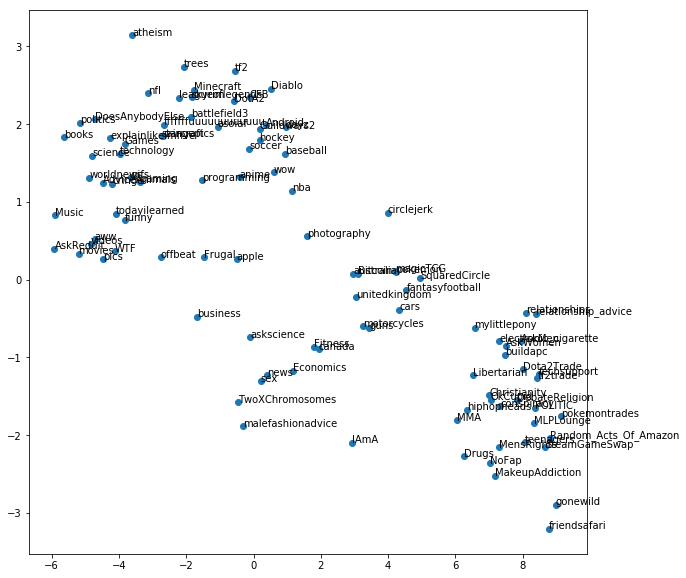

In [31]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_df[0].values, tsne_df[1].values)
for i, txt in enumerate(tsne_df.index):
    plt.annotate(txt, (tsne_df.values[i,0], tsne_df.values[i,1]))
plt.show()

Looking across this plot, we can spot a few interpretable-looking groupings:

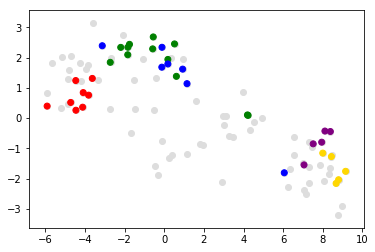

In [32]:
games = ["battlefield3", "Diablo", "DotA2", "Guildwars2", "leagueoflegends", "magicTCG", "Minecraft", "pokemon", "skyrim", "starcraft", "tf2", "wow"]
trade = ["Dota2Trade", "pokemontrades", "SteamGameSwap", "tf2trade", "Random_Acts_Of_Amazon"]
sports = ["baseball", "CFB", "hockey", "MMA", "nba", "nfl", "soccer"]

link_aggregators = ["AskReddit", "WTF", "pics", "gifs", "aww", "funny", "todayilearned",
                   "AdviceAnimals"]
relationships = ["AskMen", "AskWomen", "relationships", "relationship_advice", "OkCupid"]

plt.scatter(tsne_df[0].values, tsne_df[1].values, color="#dddddd")
plt.scatter(tsne_df[0].values, tsne_df[1].values, color=[
    "green" if l in games else
    "gold" if l in trade else
    "purple" if l in relationships else
    "red" if l in link_aggregators else
    "blue" if l in sports else
    "#00000000"
    for l in tsne_df.index])
plt.show()

For instance, video games (e.g., tf2, DotA2; red) tend to group together, along with buy-sell subreddits (e.g., tf2trade, Dota2Trade, yellow), subreddits related to relationships (e.g., AskWomen, relationship_advice; green) and large default-subreddit hubs for sharing random links (e.g., pics, AskReddit; purple).

There may be other interesting groupings that you may spot as well -- for instance, a vaguely right-wing MensRights cluster (with Libertarian, guns); a rather intriguing cluster consisting of politics, sex, business, etc.

Some topical groups are more diffuse -- for instance, sports-based subreddits (blue). Perhaps this is a limitation of our representation, or that these subreddits actually foster very different interactional dynamics.

Another way to delve into these groupings is to look at nearest neighbors of subreddits, in terms of the embedding:

In [33]:
dists = pairwise_distances(subreddit_df.values, metric='cosine')
flat_dists = np.ravel(dists)
idx1, idx2 = np.unravel_index(np.arange(len(flat_dists)), dists.shape)
pairwise_dist_df = pd.DataFrame.from_dict({'p1': subreddit_df.index[idx1],
                                           'p2': subreddit_df.index[idx2],
                                           'dist': flat_dists},
                                           orient='columns')

In [34]:
def print_nearest_neighbors(pairwise_dist_df, 
                           test_subreddits=[],
                           top_N=10):
    for subreddit in test_subreddits:
        subset_df = pairwise_dist_df[(pairwise_dist_df.p1 == subreddit)
                                 & (pairwise_dist_df.p2 != subreddit)]
        print(subreddit)
        print(subset_df.sort_values('dist')[['p2', 'dist']].head(top_N))
        print()

In [35]:
print_nearest_neighbors(pairwise_dist_df, ['apple', 'politics', 'leagueoflegends',
                                          'AskWomen', 'Music', 'pics',
                                          'australia', 'Random_Acts_Of_Amazon',
                                          'Bitcoin', 'MensRights'])

apple
               p2      dist
3616       Frugal  0.030070
3635        anime  0.050179
3637   askscience  0.051059
3681  programming  0.069621
3687       soccer  0.080355
3699          wow  0.081542
3646     business  0.089627
3672          nba  0.099240
3665       hockey  0.104839
3618   Guildwars2  0.119769

politics
                     p2      dist
8084            science  0.034676
8044              books  0.038953
8010    DoesAnybodyElse  0.048935
8017              Games  0.057288
8055  explainlikeimfive  0.060507
8089         technology  0.068854
8051             cringe  0.085648
8074                nfl  0.085750
8098          worldnews  0.091782
8000      AdviceAnimals  0.097277

leagueoflegends
                       p2      dist
6657  fffffffuuuuuuuuuuuu  0.011572
6686               skyrim  0.011675
6625            Minecraft  0.020746
6688            starcraft  0.023673
6643         battlefield3  0.025609
6695                trees  0.035354
6652           cringepics  0.0375

We can also try to interpret each dimension of the embedding -- roughly speaking the threads, features and subreddits with extremal values along one dimension could be seen as characterizing a particular "type" of discussion, in terms of the discussion structure.

In [36]:
from IPython.display import display

In [37]:
def display_dimension(dim, ascending=True, n=5):
    top_threads = U_df.sort_values(dim, ascending=ascending).head(n)
    display(top_threads)
    display(V_df.sort_values(dim, ascending=ascending).head(n))
    display(subreddit_df.sort_values(dim, ascending=ascending).head(n))
    return top_threads.index

For instance, the first latent dimension divides the space of Reddit discussions between focused dialogues involving 2 people who repeatedly interact, and "expansionary" threads involving multiple people who generally only engage once (as with the corresponding dimension discussed in the paper, this echoes the contrast explored in papers such as Backstrom et. al, 2013). At the subreddit level, we see a divide between subreddits that are selling things (perhaps the dialogues consist of a buyer and a seller) and large default link-sharing subreddits like AskReddit and pics.

In [38]:
top_threads = display_dimension(0, n=10)

,0,1,2,3,4,5,6,subreddit
t1_c30p14n,-0.936544,0.013817,-0.231156,-0.060210,0.000908,-0.245499,-0.073249,news
t1_c0i2pbg,-0.932748,-0.032660,-0.103937,0.071713,-0.000833,-0.335784,0.014766,relationship_advice
t1_c242ehj,-0.931058,0.120076,-0.283839,-0.116414,-0.008175,0.053688,-0.147129,gifs
t1_c1cbhee,-0.926751,0.032078,-0.132364,0.071352,0.001125,-0.326596,0.104047,anime
t1_c324520,-0.916631,0.021609,-0.312128,0.078563,0.003412,-0.135310,0.193401,videos
t1_c33vius,-0.915472,0.002587,-0.395634,-0.011429,-0.008175,0.057372,0.043451,atheism
t1_c52j0pq,-0.914737,-0.118301,-0.164741,0.052943,0.001152,-0.308261,0.155862,dayz
t1_c03s35m,-0.912877,0.089610,-0.213588,0.088666,-0.003959,-0.324003,0.012246,business
t1_c3307qc,-0.911327,-0.087456,-0.175860,0.128604,0.005051,-0.311797,0.130864,magicTCG
t1_c2zbrg7,-0.911309,0.170280,-0.218013,-0.166216,-0.005507,-0.117394,-0.227049,funny


,0,1,2,3,4,5,6
entropy[outdegree over C->C responses],-0.778350,-0.313614,-0.234662,0.379101,-0.004510,-0.231057,0.208867
entropy[outdegree over C->c responses],-0.778248,-0.313671,-0.234733,0.379147,-0.004510,-0.231161,0.208884
is-present[incoming triads],-0.631826,-0.440126,-0.250382,-0.549754,0.004077,0.205043,-0.010252
max[indegree over C->c responses],-0.580476,0.680057,0.096855,-0.189643,0.000997,-0.344810,0.190600
max[indegree over c->c responses],-0.580476,0.680057,0.096855,-0.189643,0.000997,-0.344810,0.190600
norm.max[indegree over C->c responses],-0.580475,0.680059,0.096842,-0.189638,0.002838,-0.344815,0.190585
norm.max[indegree over c->c responses],-0.580475,0.680059,0.096842,-0.189638,0.002838,-0.344815,0.190585
argmax[outdegree over C->C responses],-0.525875,-0.251225,-0.348497,0.649507,-0.032917,-0.240206,-0.241351
argmax[outdegree over C->c responses],-0.525857,-0.251488,-0.347983,0.649699,-0.032913,-0.239633,-0.241908
is-present[external reciprocity motif],-0.501334,-0.789581,0.005418,-0.214926,0.006038,-0.238498,-0.148612


,0,1,2,3,4,5,6
subreddit,,,,,,,
aww,-0.960970,-0.159120,0.030184,0.109992,-0.009747,-0.126123,-0.149013
videos,-0.955170,-0.089274,-0.020132,0.207658,-0.006947,-0.119120,-0.148038
pics,-0.950276,-0.168515,0.028635,0.210122,-0.005838,-0.146719,-0.045226
WTF,-0.937455,-0.243749,-0.055945,0.190024,-0.006198,-0.144986,0.038295
todayilearned,-0.896289,-0.277470,-0.103193,0.283104,-0.008190,-0.088958,-0.144565
funny,-0.891550,-0.292657,-0.139594,0.289076,-0.007669,-0.124970,-0.027609
cringe,-0.886655,-0.300494,-0.186404,0.212757,-0.011465,-0.018509,-0.207508
Music,-0.885301,0.226940,-0.125336,-0.039563,-0.011312,0.021876,-0.383221
AdviceAnimals,-0.878530,-0.344693,-0.027197,0.100216,-0.011259,-0.078868,-0.303713


In [39]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

t1_c30p14n
IranRPCV
    [deleted-t1_c30p14n]
        Hasbara_alert
            [deleted-t1_c30p14n]
    TheCid
        cholo_aleman
        madagent
    [deleted-t1_c30p14n]
        IranRPCV
    PlausibleAnswer

t1_c0i2pbg
hotntrashy
    byron
        hotntrashy
            byron
                [deleted-t1_c0i2pbg]
                    ntou45
                    foonly
    gcandela
    snissn
    sutherlandryan

t1_c242ehj
triad203
    [deleted-t1_c242ehj]
    wasanewtbutgotbetter
        tokomini
            [deleted-t1_c242ehj]
                [deleted-t1_c242ehj]
                    stlunatic15
        HenkPoley
    xkontemplatex
    RupeyDoop

t1_c1cbhee
Arronwy
    Fabien4
        Arronwy
            Fabien4
                thephotoman
    Atemesk
        mute_requiem
        zauric
    Set_it_right
    squidwalk

t1_c324520
[deleted-t1_c324520]
    Mr_Titicaca
        TheClausdawg
        trollpimp
            [deleted-t1_c324520]
    [deleted-t1_c324520]
    Jackomo
    [deleted

In [40]:
top_threads = display_dimension(0, ascending=False, n=10)

,0,1,2,3,4,5,6,subreddit
t1_c150jnj,0.978067,0.07523,-0.090095,0.060287,-0.004681,0.004268,0.161041,buildapc
t1_c5m4inf,0.978067,0.07523,-0.090095,0.060287,-0.004681,0.004268,0.161041,AskMen
t1_c1p37pc,0.977819,0.14340,0.059326,0.001418,0.000757,0.066971,0.123690,pokemontrades
t1_c0vxcku,0.977819,0.14340,0.059326,0.001418,0.000757,0.066971,0.123690,techsupport
t1_ccxpw56,0.977819,0.14340,0.059326,0.001418,0.000757,0.066971,0.123690,friendsafari
t1_c1ru65t,0.977819,0.14340,0.059326,0.001418,0.000757,0.066971,0.123690,pokemontrades
t1_c310a4i,0.977819,0.14340,0.059326,0.001418,0.000757,0.066971,0.123690,pokemontrades
t1_c1lgmox,0.977819,0.14340,0.059326,0.001418,0.000757,0.066971,0.123690,pokemontrades
t1_ccxjnxq,0.977819,0.14340,0.059326,0.001418,0.000757,0.066971,0.123690,friendsafari
t1_c31hpo4,0.977819,0.14340,0.059326,0.001418,0.000757,0.066971,0.123690,techsupport


,0,1,2,3,4,5,6
prop-multiple[outdegree over C->C responses],0.966912,0.159010,0.104238,-0.104034,0.012468,0.132266,-0.021428
prop-multiple[outdegree over C->c responses],0.966884,0.159102,0.104267,-0.103993,0.012468,0.132374,-0.021400
count[reciprocity motif over mid-thread],0.966256,0.054068,0.065199,-0.192973,-0.001994,0.038151,0.143097
count[reciprocity motif],0.904244,0.165110,0.019088,-0.343040,-0.000406,0.181179,-0.064917
2nd-largest[outdegree over C->C responses],0.902369,0.162259,0.036324,0.350709,-0.003533,-0.182728,0.041026
2nd-largest[outdegree over C->c responses],0.902355,0.162339,0.036318,0.350709,-0.003536,-0.182777,0.040815
mean[outdegree over C->C mid-thread responses],0.874562,0.159165,0.414601,0.115918,0.000681,-0.152399,0.035379
mean[indegree over C->C mid-thread responses],0.874562,0.159165,0.414601,0.115918,0.000681,-0.152399,0.035379
mean[outdegree over C->c mid-thread responses],0.874250,0.159562,0.415246,0.116102,0.000685,-0.152026,0.034714
count[outgoing triads over mid-thread],0.871051,0.160478,0.255668,-0.329248,-0.004913,0.135684,-0.152684


,0,1,2,3,4,5,6
subreddit,,,,,,,
tf2trade,0.983629,-0.020536,0.036690,-0.152410,-0.002661,0.051421,0.069472
techsupport,0.979239,-0.026278,0.077388,-0.168430,-0.001796,0.042807,0.064859
Dota2Trade,0.978355,-0.143584,-0.030161,-0.119594,-0.003535,0.052136,0.065290
POLITIC,0.977363,0.079443,0.008683,-0.168986,-0.003593,0.097962,-0.014439
MLPLounge,0.969376,0.091627,-0.208062,-0.060838,-0.004987,0.063395,0.029675
DebateReligion,0.952047,-0.064110,-0.181926,-0.232206,-0.006137,0.002685,-0.049350
buildapc,0.948819,-0.245468,-0.085870,-0.110015,-0.004081,0.138305,0.029427
Random_Acts_Of_Amazon,0.943058,0.300861,-0.117672,-0.032005,-0.003161,0.072024,0.007515
SteamGameSwap,0.931828,0.309179,-0.107986,-0.139223,-0.003766,0.069816,0.013120


In [41]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

t1_c150jnj
rasmusdf
    [deleted-t1_c150jnj]
        [deleted-t1_c150jnj]
            DoTheEvolution
                [deleted-t1_c150jnj]
                    DoTheEvolution
                        [deleted-t1_c150jnj]
                            DoTheEvolution
                                [deleted-t1_c150jnj]
                                    DoTheEvolution

t1_c5m4inf
significantshrinkage
    [deleted-t1_c5m4inf]
        [deleted-t1_c5m4inf]
            Ranalysis
                [deleted-t1_c5m4inf]
                    Ranalysis
                        [deleted-t1_c5m4inf]
                            Ranalysis
                                [deleted-t1_c5m4inf]
                                    Ranalysis

t1_c1p37pc
Kingofloss
    SykoNytro
        Kingofloss
            SykoNytro
                Kingofloss
                    SykoNytro
                        Kingofloss
                            SykoNytro
                                SykoNytro
                           

Another "type" of discussion surfaced at the extreme of another latent dimension corresponds to discussions which have a lot of activity in the middle of the thread, below the root  comment (indicated by the various mid-thread features which come to the fore). Subreddits here are often about more specialized topics -- e.g., programming, Bitcoin, cars.

In [42]:
top_threads = display_dimension(1,  n=10)

,0,1,2,3,4,5,6,subreddit
t1_c08lgn5,0.108112,-0.975852,-0.078264,-0.093172,-0.006081,0.078837,0.122335,movies
t1_c0fpmtn,-0.073153,-0.965866,0.198559,0.073715,-0.005246,-0.127671,0.023754,soccer
t1_c2zoamy,0.050072,-0.928927,0.259444,0.093473,0.004715,-0.115215,0.212705,battlefield3
t1_c2yh2do,-0.292468,-0.928501,0.033309,-0.186047,-0.007505,0.074891,0.104694,pics
t1_c12vvbp,-0.016006,-0.928094,-0.215974,0.115887,-0.002999,-0.211517,0.183199,baseball
t1_c32w92g,-0.163909,-0.921269,0.118316,0.266969,0.001672,0.134204,0.145302,guns
t1_c2blrqi,-0.207396,-0.919636,-0.023468,0.033906,-0.005763,0.325462,0.059984,asoiaf
t1_c2kru3b,-0.207396,-0.919636,-0.023468,0.033906,-0.005763,0.325462,0.059984,DotA2
t1_c05cca8,-0.168557,-0.918538,-0.267887,0.096207,-0.004573,-0.179879,-0.120329,offbeat
t1_c3t79gl,0.045038,-0.917555,-0.002292,-0.276402,0.001928,-0.154065,0.236477,teenagers


,0,1,2,3,4,5,6
is-present[external reciprocity motif over mid-thread],-0.189719,-0.943027,-0.045041,-0.022449,0.009535,0.094779,0.251199
count[external reciprocity motif over mid-thread],-0.179231,-0.864702,0.017160,0.143003,0.000353,0.012229,0.446400
is-present[incoming triads over mid-thread],-0.187946,-0.812878,0.456477,-0.291783,-0.006479,-0.042959,-0.092244
is-present[external reciprocity motif],-0.501334,-0.789581,0.005418,-0.214926,0.006038,-0.238498,-0.148612
count[external reciprocity motif],-0.391387,-0.773953,0.224713,0.202467,0.001904,-0.211734,0.333902
entropy[outdegree over c->c mid-thread responses],0.430381,-0.758416,0.266319,-0.015236,0.003847,0.098765,0.398309
prop-nonzero[outdegree over c->c mid-thread responses],0.470159,-0.753950,0.288438,-0.113822,0.001855,-0.065169,0.331823
mean[outdegree over c->c mid-thread responses],0.470159,-0.753950,0.288438,-0.113822,0.001855,-0.065169,0.331823
mean[indegree over c->c mid-thread responses],0.470159,-0.753950,0.288438,-0.113822,0.001855,-0.065169,0.331823
mean[indegree over C->c mid-thread responses],0.470159,-0.753950,0.288438,-0.113822,0.001855,-0.065169,0.331823


,0,1,2,3,4,5,6
subreddit,,,,,,,
dayz,-0.180131,-0.912199,-0.309860,0.195330,-0.009310,0.034527,-0.000848
guns,0.380175,-0.905743,-0.095460,-0.061258,-0.009810,0.071807,-0.130306
nba,-0.111627,-0.899572,-0.255662,0.159116,-0.013444,0.165925,-0.244780
Bitcoin,0.268979,-0.874438,-0.325931,0.062818,-0.013204,0.102696,-0.205208
wow,-0.247178,-0.814380,-0.457081,0.105640,-0.013856,0.114757,-0.205533
canada,0.116061,-0.806939,-0.044013,-0.308832,-0.014406,0.144564,-0.465788
Fitness,-0.037914,-0.806765,-0.156381,-0.413835,-0.012398,0.231145,-0.313683
soccer,-0.341902,-0.805146,-0.344078,0.216985,-0.015097,-0.073303,-0.252526
hockey,-0.292352,-0.782669,-0.411014,0.308354,-0.013577,0.051551,-0.187358


In [43]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

t1_c08lgn5
[deleted-t1_c08lgn5]
    jtrenton
        Cronus6
            geoff422
        turkourjurbs
    [deleted-t1_c08lgn5]
        Cronus6
            Cronus6
                jtrenton
                    [deleted-t1_c08lgn5]

t1_c0fpmtn
thekrone
    TheMemoman
        thekrone
            rio_nemenja
            [deleted-t1_c0fpmtn]
                thekrone
                Rossoneri
                    [deleted-t1_c0fpmtn]
                severedfragile
                    [deleted-t1_c0fpmtn]

t1_c2zoamy
Rednys
    Rayezilla
        Rednys
            Rayezilla
            carmaugh
                Rednys
                [deleted-t1_c2zoamy]
                [deleted-t1_c2zoamy]
                    ragingatwork
                        Rednys

t1_c2yh2do
doubleu
    whininghippo
        IAmTheSea
            sleekanddestroy
                [deleted-t1_c2yh2do]
                    resutidder
                        [deleted-t1_c2yh2do]
                    [deleted-t1_c2yh2do]
       

The following discussion type consists of threads with a particularly active latecomer (indicated by the argmax[outdegree... features). 

In [44]:
top_threads = display_dimension(2,  n=10)

,0,1,2,3,4,5,6,subreddit
t1_c0a4atr,0.015447,-0.005305,-0.999669,0.008896,-0.013981,0.010842,0.001729,tf2
t1_c0h431e,-0.021627,0.028873,-0.998605,-0.035818,-0.012245,-0.007318,-0.000224,australia
t1_c0dv2yx,-0.019635,0.034818,-0.998401,-0.038065,-0.011856,0.002597,0.000848,Android
t1_c2x9lem,-0.019635,0.034818,-0.998401,-0.038065,-0.011856,0.002597,0.000848,asoiaf
t1_c4usuk4,-0.022452,0.049224,-0.997254,-0.048143,-0.010912,0.009546,0.005438,AskWomen
t1_c09zl9l,-0.018932,0.010942,-0.996398,-0.048661,-0.010950,0.007208,0.064596,Frugal
t1_c1efb8t,-0.009933,-0.029369,-0.993752,0.033442,-0.018395,0.099885,-0.007927,baseball
t1_c077hit,-0.051477,-0.051612,-0.993709,-0.024182,-0.014301,0.010619,-0.079540,Music
t1_c2qw0fe,0.022974,0.012953,-0.993446,0.064516,-0.009458,0.025512,0.086411,gifs
t1_c06yuud,-0.052654,0.006154,-0.993367,-0.098009,-0.010949,0.022872,0.012770,news


,0,1,2,3,4,5,6
entropy[indegree over C->C mid-thread responses],-0.124899,-0.489815,-0.730977,0.293533,-0.001615,0.232400,0.264539
entropy[indegree over c->c mid-thread responses],0.597368,-0.298487,-0.617813,0.109219,-0.004357,0.236056,0.323564
entropy[indegree over C->c mid-thread responses],0.597368,-0.298487,-0.617813,0.109219,-0.004357,0.236056,0.323564
prop-nonzero[indegree over c->c mid-thread responses],0.705634,-0.337262,-0.562159,-0.018869,-0.006521,-0.081548,0.255467
prop-nonzero[indegree over C->c mid-thread responses],0.705634,-0.337262,-0.562159,-0.018869,-0.006521,-0.081548,0.255467
prop-nonzero[indegree over c->c responses],0.705634,-0.337262,-0.562159,-0.018869,-0.006521,-0.081548,0.255467
prop-nonzero[indegree over C->c responses],0.705634,-0.337262,-0.562159,-0.018869,-0.006521,-0.081548,0.255467
entropy[indegree over C->C responses],-0.184008,-0.735924,-0.559342,0.329067,-0.004404,-0.004326,0.058053
prop-nonzero[indegree over C->C mid-thread responses],0.770032,-0.279671,-0.546032,-0.122385,0.006551,0.122643,0.024930
prop-nonzero[indegree over C->C responses],0.768969,-0.292115,-0.545098,-0.093644,0.006332,0.127827,0.032785


,0,1,2,3,4,5,6
subreddit,,,,,,,
circlejerk,0.221107,-0.613646,-0.699670,-0.068109,-0.018824,-0.101537,0.264026
SquaredCircle,0.629350,-0.450323,-0.632548,0.016849,-0.016540,-0.015232,0.014854
Android,-0.290776,-0.688880,-0.590937,0.235721,-0.015190,0.063020,-0.178663
Diablo,-0.199883,-0.755798,-0.569583,0.214211,-0.015412,-0.129718,-0.037959
photography,-0.019494,-0.668415,-0.550452,0.050470,-0.016973,0.218360,-0.446462
tf2,-0.444176,-0.691549,-0.518300,0.207427,-0.011660,-0.103507,0.044243
magicTCG,0.493232,-0.683769,-0.517547,0.126808,-0.011890,0.060912,-0.037353
baseball,-0.098792,-0.746041,-0.505978,0.309948,-0.015727,0.028104,-0.283805
australia,0.249730,-0.766121,-0.498729,-0.053772,-0.016694,0.134668,-0.284003


In [45]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

t1_c0a4atr
Maxxist
    isankit
        badjoke33
    elephantitis
        Facelessjoe
            elephantitis
    TheCid
        badjoke33
            TheCid
                badjoke33

t1_c0h431e
LuckyBdx4
    rainer511
        CaptainKernel
            DeepGreen
    big80smullet
        LuckyBdx4
    [deleted-t1_c0h431e]
        LuckyBdx4
            [deleted-t1_c0h431e]
                LuckyBdx4

t1_c0dv2yx
Xiol
    danielbln
        barryicide
            AttackingHobo
    AlwaysDownvoted-
        Xiol
    mental-midget
        Xiol
            mental-midget
                Xiol

t1_c2x9lem
officemonkey
    fanolato2
        HaroldHood
            DireBaboon
    Arthur_Dayne
        officemonkey
    AT_tHE_mIST
        officemonkey
            AT_tHE_mIST
                officemonkey

t1_c4usuk4
atomicatsplosion
    burn_that
        jameson71
            [deleted-t1_c4usuk4]
    Graenn
        atomicatsplosion
    Viend
        atomicatsplosion
            Viend
                at

And as a final example, this dimension splits the space between threads that are perfectly "flat": many comments replying to a single root (note that there are many threads of this form which share the exact same hypergraph topology as a result); and deeper discussions where multiple participants are highly active (indicated by e.g., the 2nd largest / largest, and prop-multiple features). At a higher level of aggregation we see a split between subreddits for making trades, and subreddits which are potentially more discussion-based.

In [46]:
top_threads = display_dimension(5,  n=10)

,0,1,2,3,4,5,6,subreddit
t1_c3w5355,0.290252,-0.049327,0.071004,0.049068,-0.001577,-0.949171,-0.070313,SteamGameSwap
t1_c1mx8b2,-0.116857,-0.060112,0.199951,-0.205613,-0.005279,-0.948915,0.002419,nba
t1_c31up5t,-0.092544,-0.265743,0.020714,-0.111829,-0.009424,-0.948068,-0.094657,DebateReligion
t1_c06tx78,-0.061705,0.273418,-0.140417,-0.030595,0.004339,-0.945929,-0.077341,sex
t1_c281z27,0.106685,-0.066493,0.283720,-0.000817,-0.006093,-0.942448,-0.124312,tf2trade
t1_c39j7eu,-0.122987,-0.248876,-0.120137,0.054513,-0.008614,-0.941186,-0.140091,SquaredCircle
t1_c1keacc,0.070073,-0.184690,0.203725,-0.153670,-0.005324,-0.940537,0.105940,nba
t1_c30ubnc,-0.078590,-0.208306,0.029034,0.085003,0.005804,-0.940036,0.242202,CFB
t1_c325jah,-0.217797,-0.173197,0.031034,0.163067,0.004131,-0.938410,0.119930,DebateReligion
t1_c15fdqz,0.177188,-0.133513,0.198523,-0.111147,0.000802,-0.937039,0.144813,motorcycles


,0,1,2,3,4,5,6
argmax[indegree over c->c mid-thread responses],-0.057275,0.061310,0.109358,-0.181067,-0.016884,-0.601583,-0.765525
argmax[indegree over C->c mid-thread responses],-0.057275,0.061310,0.109358,-0.181067,-0.016884,-0.601583,-0.765525
2nd-largest / max[outdegree over C->c responses],0.106504,0.079694,0.096347,0.829710,-0.003140,-0.523201,0.104188
2nd-largest / max[outdegree over C->C responses],0.106495,0.079836,0.096503,0.829802,-0.003139,-0.522967,0.104389
2nd-argmax[outdegree over C->c responses],-0.179920,-0.125348,-0.289547,0.775385,-0.016704,-0.506546,-0.099947
2nd-argmax[outdegree over C->C responses],-0.179865,-0.125494,-0.289539,0.775535,-0.016706,-0.506285,-0.100044
argmax[indegree over C->c responses],0.149144,-0.271353,0.390910,-0.325960,0.004471,-0.504515,0.624906
argmax[indegree over c->c responses],0.149144,-0.271353,0.390910,-0.325960,0.004471,-0.504515,0.624906
max[indegree over C->c mid-thread responses],-0.159098,-0.365239,0.702958,-0.289883,0.005695,-0.499523,0.116402
max[indegree over c->c mid-thread responses],-0.159098,-0.365239,0.702958,-0.289883,0.005695,-0.499523,0.116402


,0,1,2,3,4,5,6
subreddit,,,,,,,
atheism,-0.691415,-0.517641,0.007155,-0.113495,-0.020020,-0.487741,-0.052612
IAmA,-0.014974,-0.681863,0.425996,-0.228211,0.001471,-0.219178,0.503234
trees,-0.645749,-0.624011,-0.324468,0.184577,-0.011568,-0.210903,0.098269
Minecraft,-0.590720,-0.666440,-0.266694,0.314137,-0.010683,-0.189390,-0.033425
AskReddit,-0.867213,0.403870,-0.060958,0.102579,-0.006348,-0.188825,-0.186805
gifs,-0.844974,-0.338611,-0.247453,0.257804,-0.010880,-0.185389,-0.095800
movies,-0.877556,0.008537,-0.330101,0.283228,-0.009626,-0.184571,-0.080492
politics,-0.734891,-0.223703,-0.372622,0.113989,-0.019295,-0.183577,-0.473264
gaming,-0.843037,-0.422391,-0.087144,0.275420,-0.007534,-0.158281,-0.048107


In [47]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

t1_c3w5355
Pulviriza
    Provider92
        [deleted-t1_c3w5355]
            Provider92
                [deleted-t1_c3w5355]
                LadyWar
                    Provider92
                        LadyWar
    [deleted-t1_c3w5355]
    hooliog

t1_c1mx8b2
sabretoothvc
    catmoon
        sabretoothvc
            arbysguy
            clever_user_name
            dboti
                sabretoothvc
                    dboti
                        sabretoothvc
    ImpatientSoul

t1_c31up5t
Coraon
    khafra
        Coraon
            mescad
    themuffins
        Coraon
            [deleted-t1_c31up5t]
                Coraon
                dasbush
                [deleted-t1_c31up5t]

t1_c06tx78
[deleted-t1_c06tx78]
    [deleted-t1_c06tx78]
        [deleted-t1_c06tx78]
            [deleted-t1_c06tx78]
            escape_goat
    kru5h
    topsul
        fuzzo
            topsul
                fuzzo

t1_c281z27
izzalion
    72pintohatchback
        RorySBarnes
    Filo92
        izz

In [48]:
top_threads = display_dimension(5, ascending=False, n=10)

,0,1,2,3,4,5,6,subreddit
t1_c3242o0,-0.155248,-0.063987,0.097297,-0.038135,0.005622,0.974827,-0.102773,leagueoflegends
t1_c30j9hw,-0.151349,-0.076417,0.109809,-0.093875,0.007196,0.974352,-0.031153,skyrim
t1_c3v4d9g,-0.156472,-0.046146,0.089985,-0.011620,0.004899,0.970500,-0.152512,MakeupAddiction
t1_c0a8idx,-0.012316,-0.118729,0.182399,0.047672,0.007142,0.969995,-0.096269,Drugs
t1_c13fu53,0.002864,-0.016661,0.148176,-0.069568,0.006145,0.967742,-0.190674,relationships
t1_c32nrps,-0.106951,-0.031114,0.100278,0.077792,0.004129,0.967038,-0.190545,guns
t1_c39cjn0,-0.068323,-0.145099,0.072786,0.024687,0.003273,0.965785,-0.188731,NoFap
t1_c5fmc70,-0.092447,-0.094991,0.147109,0.127426,0.006451,0.965673,-0.109477,Dota2Trade
t1_c3jqc1f,-0.099784,-0.024733,0.122233,-0.041176,0.004257,0.965455,-0.201675,SquaredCircle
t1_c09sip6,-0.131288,-0.040083,0.099275,0.068640,0.004269,0.964340,-0.191366,conspiracy


,0,1,2,3,4,5,6
2nd-largest / max[indegree over C->c mid-thread responses],0.097732,0.068649,-0.267578,0.402215,0.002654,0.866736,0.033505
2nd-largest / max[indegree over c->c mid-thread responses],0.097732,0.068649,-0.267578,0.402215,0.002654,0.866736,0.033505
norm.2nd-largest[indegree over C->c mid-thread responses],-0.210354,0.144065,0.204567,0.352814,0.005017,0.832212,0.275807
norm.2nd-largest[indegree over c->c mid-thread responses],-0.210354,0.144065,0.204567,0.352814,0.005017,0.832212,0.275807
2nd-argmax[indegree over c->c mid-thread responses],-0.131402,0.040663,0.164707,0.369335,-0.000505,0.816895,-0.387590
2nd-argmax[indegree over C->c mid-thread responses],-0.131402,0.040663,0.164707,0.369335,-0.000505,0.816895,-0.387590
2nd-largest[indegree over c->c mid-thread responses],-0.034151,-0.411335,0.390639,0.283916,0.005059,0.757036,-0.152647
2nd-largest[indegree over C->c mid-thread responses],-0.034151,-0.411335,0.390639,0.283916,0.005059,0.757036,-0.152647
2nd-largest / max[outdegree over c->c mid-thread responses],0.126600,-0.355845,0.056865,0.481836,0.007533,0.634470,0.468335
prop-multiple[indegree over c->c mid-thread responses],-0.240511,-0.224721,0.780076,0.165180,0.006687,0.501247,0.067524


,0,1,2,3,4,5,6
subreddit,,,,,,,
Drugs,0.560323,-0.374914,-0.010739,-0.557703,-0.007549,0.358684,-0.324989
news,-0.111284,-0.446908,-0.251112,-0.188734,-0.019121,0.339601,-0.757310
MakeupAddiction,0.732677,0.033939,-0.254858,-0.389068,-0.009020,0.328949,-0.370699
NoFap,0.727833,-0.138544,0.144326,-0.489959,-0.006741,0.319677,-0.296539
MMA,0.649496,-0.416610,-0.158780,-0.317167,-0.013766,0.291827,-0.439809
malefashionadvice,-0.178715,0.090478,-0.479295,-0.424645,-0.016862,0.278188,-0.687135
motorcycles,0.385689,-0.762827,-0.266872,-0.225678,-0.012297,0.273684,-0.268577
MensRights,0.831539,-0.070378,0.011758,-0.375197,-0.006435,0.266438,-0.302734
friendsafari,0.377546,0.767588,-0.211379,-0.332077,-0.004930,0.263956,-0.208839


In [49]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

t1_c3242o0
Snoopy_Hates_Germans
    CorAutMors
        Jacuzzi_Pete
        Snoopy_Hates_Germans
            CorAutMors
            dgapinski
                Snoopy_Hates_Germans
    dgapinski
    [deleted-t1_c3242o0]
        Snoopy_Hates_Germans

t1_c30j9hw
Jakad
    [deleted-t1_c30j9hw]
        Jakad
            [deleted-t1_c30j9hw]
            c0meary
                Jakad
        zaggeh
    Khorpo
        Jakad
    Khorpo

t1_c3v4d9g
duckrodeo
    moonbeamwhim
        alaskan_princess
        duckrodeo
            moonbeamwhim
            canhazhotness
                duckrodeo
    alaskan_princess
        duckrodeo
    Felonia

t1_c0a8idx
cyantist
    kryptobs2000
        [deleted-t1_c0a8idx]
            rofld
                kryptobs2000
            kryptobs2000
        cyantist
            kryptobs2000
    [deleted-t1_c0a8idx]
    [deleted-t1_c0a8idx]

t1_c13fu53
[deleted-t1_c13fu53]
    givemeadviceplease
        [deleted-t1_c13fu53]
        [deleted-t1_c13fu53]
            giv

This dimension highlights two interesting points:

* discussion structures, as in the Facebook data, might help us draw interesting parallels between subreddits which are topically different (e.g., politics, business and sex -- certainly a somewhat clickbaity grouping). Of course, one should delve deeper into the interpretation than what we've presented here in order to make sense of this.
* There might be aspects of the _tree_ structure that we could delve into further. Reddit, in contrast to Facebook, explicitly renders all branching in the discussion tree beyond the first reply. Might there be different interactional dynamics on the two platforms as a result of this, or additional features we may have  presently neglected to include, that become especially salient on Reddit?